## Import library 

In [1]:
import random
import os

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from PIL import Image

## Config

In [2]:
class CFG:
    def __init__(self):

        self.seed=777
        self.epochs=20
        self.batch_size=64
        self.learning_rate=0.0007
        self.input_class=None
        self.output_class=2

        self.device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

        self.class_mapping = {
            "NORMAL":0,
            'PNEUMONIA':1,
        }
        

config=CFG()

def torch_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms=True
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

torch_seed(config.seed)

## Load data

## Train

In [3]:
def Load(dir):
    filepaths=[]
    labels=[]

    folds=os.listdir(dir)

    for fold in folds:
        foldpath=os.path.join(dir,fold)
        filelist=os.listdir(foldpath)
        for file in filelist:
            path=os.path.join(foldpath,file)
            filepaths.append(path)
            labels.append(fold)

    X=pd.Series(filepaths,name="filepaths")
    y=pd.Series(labels,name="labels")
    df=pd.concat([X,y],axis=1)

    return df

train_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/test"
val_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/val"

train_df=Load(train_dir)
test_df=Load(test_dir)
val_df=Load(val_dir)


In [4]:
train_df.head()

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [5]:
test_df.head()

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [6]:
val_df.head()

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [7]:
train_df["labels"].value_counts()

labels
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

# Show data

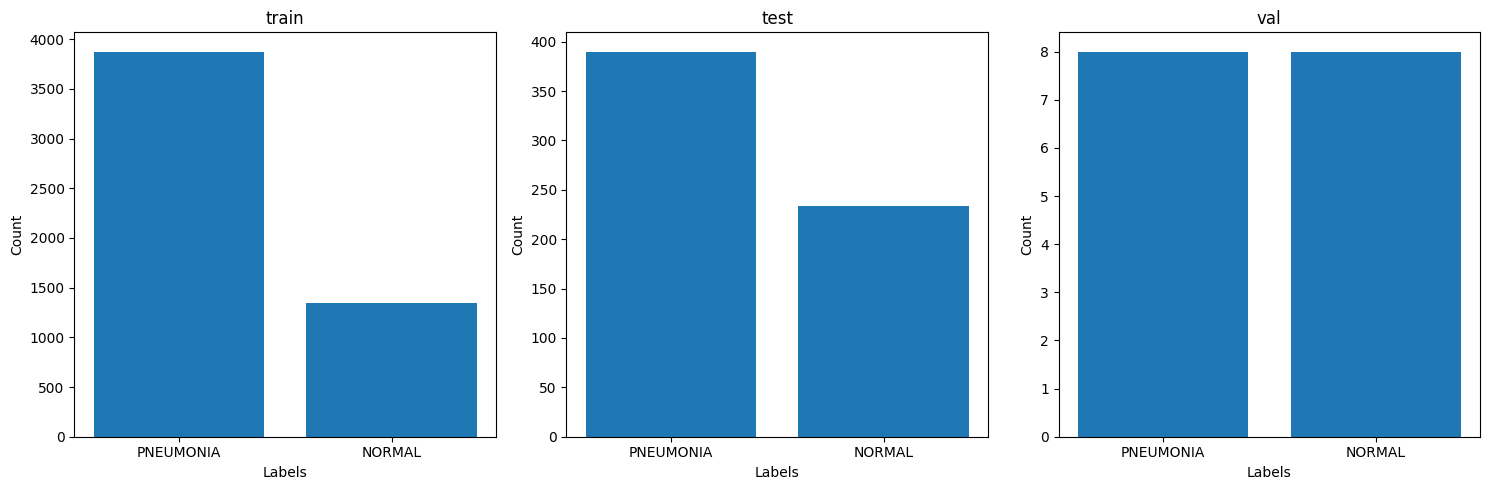

In [8]:
def Show(train_df,test_df,val_df):
    fig,axs=plt.subplots(1,3,figsize=(15,5))

    for i,(name,df) in enumerate(zip(["train","test","val"],[train_df,test_df,val_df])):
        label_counts=df["labels"].value_counts()
        axs[i].bar(label_counts.index,label_counts.values)
        axs[i].set_title(name)
        axs[i].set_xlabel('Labels')
        axs[i].set_ylabel('Count')
        axs[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

Show(train_df,test_df,val_df)

# Processing

In [9]:
def encode(df):
    df["labels"]=df["labels"].map(config.class_mapping)

encode(train_df)
encode(test_df)
encode(val_df)

In [10]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# transform = {"train":transforms.Compose([
#                                 transforms.Resize((150,150)),
#                                 transforms.Grayscale(num_output_channels=3),
#                                 transforms.RandomRotation(10), 
#                                 transforms.RandomHorizontalFlip(p=0.4), 
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean = mean_nums, std=std_nums)]), 
#                 "val": transforms.Compose([
#                             transforms.Resize((150,150)),
#                             transforms.Grayscale(num_output_channels=3),
#                             transforms.CenterCrop(150),
#                             transforms.ToTensor(),
#                             transforms.Normalize(mean=mean_nums, std = std_nums)
#                     ])}

transform = transforms.Compose([
                                transforms.Resize((512,512)),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.RandomRotation(10), 
                                transforms.RandomHorizontalFlip(p=0.4), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean_nums, std=std_nums)
                                ])

test_transform = transforms.Compose([
                                transforms.Resize((512,512)),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean_nums, std=std_nums)
                                ])

# Transform Image

In [11]:
class ImageDataset(Dataset):

    def __init__(self,filepaths,labels,transform=None):
        self.filepaths=filepaths
        self.labels=labels
        self.transform=transform
    
    def __getitem__(self,index):
        img=Image.open(self.filepaths[index])
        if self.transform is not None:
            img=self.transform(img)
        label=self.labels[index]
        return img,label
    
    def __len__(self):
        return len(self.labels)


train_dataset=ImageDataset(train_df["filepaths"],train_df["labels"],transform)
test_dataset=ImageDataset(test_df["filepaths"],test_df["labels"],test_transform)

train,valid=train_test_split(train_dataset,test_size=0.2,random_state=777)

# train,valid=train_test_split(train_df,test_size=0.2,random_state=config.seed)

# train=ImageDataset(train["filepaths"],train["labels"],transform["train"])
# valid=ImageDataset(valid["filepaths"],valid["labels"],transform["val"])

In [12]:
print(len(train))
print(len(valid))

4172
1044


# Model

In [13]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(2,stride=2)

        self.conv1=nn.Conv2d(3,16,3)
        self.conv2=nn.Conv2d(16,32,3)

        self.fc1=nn.Linear(508032,1024)
        self.fc2=nn.Linear(1024,120)
        self.fc3=nn.Linear(120,2)

    def forward(self,x):
        x=self.conv1(x)
        x-self.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        x=x.view(x.size()[0],-1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        
        return x
    
model=Model().to(device=config.device)

In [14]:
train_dataloader=DataLoader(train,batch_size=config.batch_size,shuffle=True)
valid_dataloader=DataLoader(valid,batch_size=config.batch_size,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=config.batch_size)
# batch_iterator = iter(train_dataloader)
# inputs, labels = next(batch_iterator)
# print(len(inputs))
# print(len(labels))

In [15]:
device=config.device
optimizer=Adam(model.parameters(),lr=config.learning_rate)

def train(train_dataloader):
    criterion=nn.CrossEntropyLoss()
    loss_sum=0

    model.train()
    for X,y in train_dataloader:
        X,y=X.to(device),y.to(device)
        optimizer.zero_grad()
        pred=model(X)
        loss=criterion(pred,y)
        loss_sum+=loss.item()
        loss.backward()
        optimizer.step()

    train_loss=loss_sum/len(train_dataloader)

    return train_loss

def valid(valid_dataloader):
    criterion=nn.CrossEntropyLoss()
    loss_sum=0
    correct=0
    total=0

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in valid_dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            loss=criterion(pred,y)
            loss_sum+=loss.item()
            pred=pred.max(1, keepdim=True)[1]
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
    
    val_loss=loss_sum/len(valid_dataloader)
    val_acc=correct/total
    return val_loss,val_acc

def test(test_data):
    correct=0
    total=0
    y_true=[]
    y_pred=[]

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in valid_dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            pred=pred.max(1, keepdim=True)[1]
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    test_acc=correct/total
    return test_acc,cm,y_pred

# Find best hyper_param

In [16]:
# def objective(trial):

#     #batch_size = trial.suggest_int('batch_size', 512, 2048)
#     #epochs = trial.suggest_int('epochs', 50, 300)
#     learning_rate = trial.suggest_float('learning_rate', 0.0007, 0.001)
#     layer1_out = trial.suggest_int('layer1_out', 512, 1024,step=2)
#     layer2_out = trial.suggest_int('layer2_out', 128, 512,step
#     layer3_out = trial.suggest_int('layer3_out', 64, 128,step=2)
#     drop_out = trial.suggest_float("drop_out", 0.1, 0.3,step=0.1)
#     #loss_type = trial.suggest_categorical('loss_type', ["Adam", "SGD"])
                                                               
#     device=config.device
#     model = Model(config.input_class,config.output_class,layer1_out,layer2_out,layer3_out,drop_out).to(device)
#     optimizer=Adam(model.parameters(),lr=learning_rate)

#     epochs=config.epochs
#     for step in range(epochs):
#         train(model,device,train_dataloader,optimizer)
#         error_rate=valid(model,device,valid_dataloader)
    
#     return error_rate

# # Create a study object and optimize the objective function
# study = optuna.create_study()
# study.optimize(objective, n_trials=50)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [17]:
# hyperparameters=best_params

# # ファイル名を指定します
# file_name = "hypara_pytorch2.txt"

# # テキストファイルに書き込みます
# with open(file_name, 'w') as file:
#     for key, value in hyperparameters.items():
#         file.write(f"{key}: {value}\n")


# Train

In [18]:
loss_list=[]
val_loss_list=[]
val_acc_list=[]

epochs=config.epochs
epochs=10
for epoch in range(epochs):
    loss=train(train_dataloader)
    val_loss,val_acc=valid(valid_dataloader)
    print(f"train loss : {loss}  val_loss : {val_loss}  val_acc : {val_acc} ")
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

train loss : 1.6552354715990298  val_loss : 0.1584476434132632  val_acc : 0.935823754789272 
train loss : 0.14164019607459055  val_loss : 0.12992354646763382  val_acc : 0.9482758620689655 
train loss : 0.09055080992931669  val_loss : 0.11250194315524663  val_acc : 0.9588122605363985 
train loss : 0.04671661458401517  val_loss : 0.10169458170147504  val_acc : 0.960727969348659 
train loss : 0.02094678687298614  val_loss : 0.11451400115209467  val_acc : 0.9636015325670498 
train loss : 0.00935982309409045  val_loss : 0.12256462620023419  val_acc : 0.9568965517241379 
train loss : 0.0030663769769792757  val_loss : 0.1269973752581898  val_acc : 0.960727969348659 
train loss : 0.0013388416777932875  val_loss : 0.1482011397533557  val_acc : 0.960727969348659 
train loss : 0.000715044224775876  val_loss : 0.14248819991617517  val_acc : 0.9626436781609196 
train loss : 0.0004695238038204314  val_loss : 0.1435217305963092  val_acc : 0.9636015325670498 


Text(0, 0.5, 'acc')

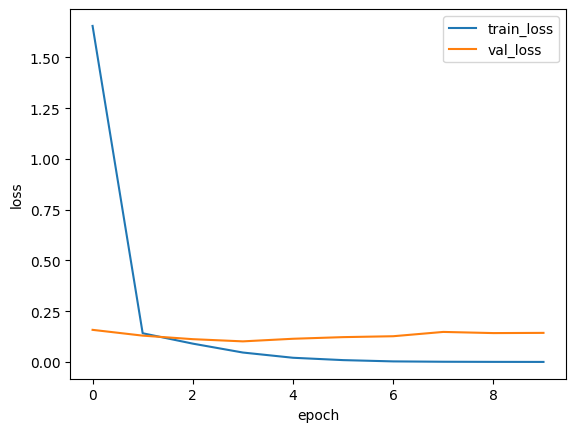

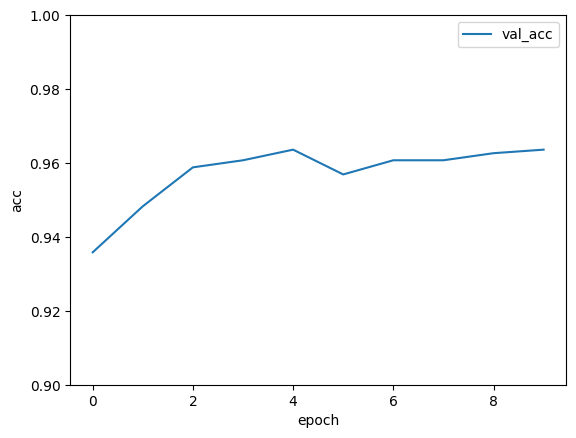

In [19]:
plt.plot(loss_list,label="train_loss")
plt.plot(val_loss_list,label="val_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.figure()
plt.plot(val_acc_list,label="val_acc")
plt.legend()
plt.ylim(0.9,1)
plt.xlabel("epoch")
plt.ylabel("acc")

# Test

0.9636015325670498


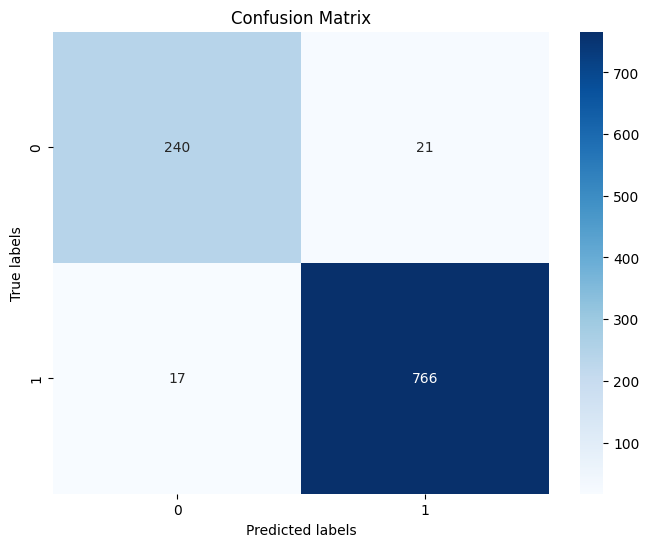

In [20]:
acc,cm,pred=test(test_dataloader)
print(acc)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()